# 1.0 Camera Demonstration 

Scaler and KNN model loaded successfully.


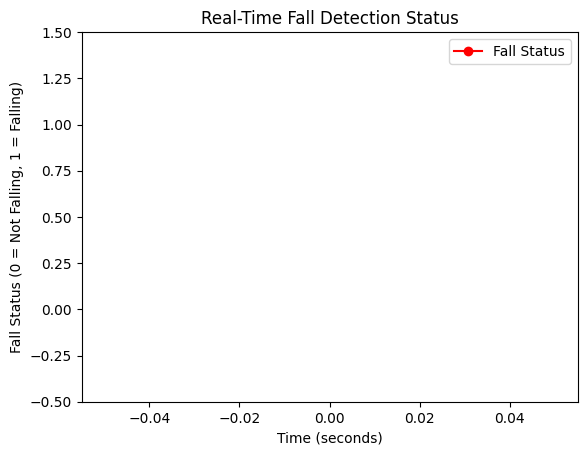

c:\Users\Ethan\Documents\Codes\CM2603-Data_Science_Project-G20\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Ethan\Documents\Codes\CM2603-Data_Science_Project-G20\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Ethan\Documents\Codes\CM2603-Data_Science_Project-G20\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Ethan\Documents\Codes\CM2603-Data_Science_Project-G20\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Ethan\Documents\Codes\CM2603-Data_Science_P


--- Fall Detection Summary ---
Total Falls Detected: 16
Falls Over 5 Seconds: 0
Fall Durations: [0.8800861835479736, 0.1504497528076172, 0.17011141777038574]
Non-Fall Durations: [0.05994987487792969, 0.08299708366394043, 0.06647467613220215]


In [1]:
import cv2 as cv
import mediapipe as mp
import numpy as np
import csv
import time
import os
import pickle
import joblib
import threading
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import datetime
from collections import deque

# ------------------ Load the scaler and KNN model ------------------

base_dir = os.getcwd()
model_dir = os.path.join(base_dir, "models" , "cam")

scaler_path = os.path.join(model_dir, "scaler.pkl")
model_path = os.path.join(model_dir, "knn_model.pkl")

try:
    scaler = joblib.load(scaler_path)  
    with open(model_path, "rb") as model_file:
        knn_model = pickle.load(model_file)
    print("Scaler and KNN model loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}\nEnsure 'scaler.pkl' and 'knn_model.pkl' exist in the 'KNN_model' folder.")
    exit(1)

# ------------------ Initialize MediaPipe Pose ------------------

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
non_face_indices = list(range(11, 33))

cap = cv.VideoCapture(0)

fall_count = 0
long_fall_count = 0
fall_start_time = None
non_fall_start_time = time.time()
fall_durations = []
non_fall_durations = []
data_log = []

fourcc = cv.VideoWriter_fourcc(*'mp4v')
fall_video_writer = None
recording = False
video_filename = None

recordings_dir = os.path.join(base_dir, "recordings")
os.makedirs(recordings_dir, exist_ok=True)

# ------------------ Data for Live Graph ------------------
time_window = 50  # Number of data points to show in the graph
time_series = deque(maxlen=time_window)
fall_series = deque(maxlen=time_window)

fig, ax = plt.subplots()
ax.set_ylim(-0.5, 1.5)
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Fall Status (0 = Not Falling, 1 = Falling)")
ax.set_title("Real-Time Fall Detection Status")
line, = ax.plot([], [], 'ro-', label="Fall Status")
ax.legend()


def update_graph(frame):
    ax.clear()
    ax.plot(time_series, fall_series, 'ro-', label="Fall Status")
    ax.set_ylim(-0.5, 1.5)
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Fall Status (0 = Not Falling, 1 = Falling)")
    ax.set_title("Real-Time Fall Detection Status")
    ax.legend()


# ------------------ Function to Run Fall Detection ------------------

def fall_detection():
    global fall_count, long_fall_count, fall_start_time, recording, fall_video_writer, video_filename
    with mp_pose.Pose(min_detection_confidence=0.3, min_tracking_confidence=0.3) as pose:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                print("Failed to capture frame.")
                break

            image = cv.resize(frame, (640, 480))
            image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            results = pose.process(image_rgb)

            current_time = time.time()
            time_series.append(round(current_time, 2))

            if results.pose_landmarks:
                height, width, _ = image.shape
                landmarks = results.pose_landmarks.landmark
                filtered_landmarks = [landmarks[i] for i in non_face_indices]

                x_coords = [lm.x * width for lm in filtered_landmarks]
                y_coords = [lm.y * height for lm in filtered_landmarks]
                visibilities = [lm.visibility for lm in filtered_landmarks]

                x_min, x_max = min(x_coords), max(x_coords)
                y_min, y_max = min(y_coords), max(y_coords)
                box_width = x_max - x_min
                box_height = y_max - y_min

                features_input = np.array([np.mean(x_coords), np.mean(y_coords), np.mean(visibilities), box_width, box_height])
                features_input_scaled = scaler.transform([features_input])

                prediction = knn_model.predict(features_input_scaled)[0]
                label = "Falling" if prediction == 1 else "Not Falling"

                fall_series.append(prediction)

                if prediction == 1:
                    if fall_start_time is None:
                        fall_start_time = current_time
                        non_fall_durations.append(current_time - non_fall_start_time)

                        timestamp_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
                        video_filename = os.path.join(recordings_dir, f"fall_{timestamp_str}.mp4")

                        fall_video_writer = cv.VideoWriter(video_filename, fourcc, 20.0, (640, 480))
                        recording = True

                    fall_count += 1

                    if recording and fall_video_writer:
                        fall_video_writer.write(frame)

                else:
                    if fall_start_time:
                        fall_duration = current_time - fall_start_time
                        fall_durations.append(fall_duration)

                        if fall_duration > 5:
                            long_fall_count += 1
                        else:
                            if recording and fall_video_writer:
                                fall_video_writer.release()
                                recording = False

                            time.sleep(0.1)
                            if video_filename and os.path.exists(video_filename):
                                try:
                                    os.remove(video_filename)
                                except PermissionError:
                                    print(f"Warning: Could not delete {video_filename}.")

                        if recording and fall_video_writer:
                            fall_video_writer.release()
                            recording = False

                        fall_start_time = None

                    non_fall_start_time = current_time

                data_log.append([round(current_time, 2), label])

                mp_drawing.draw_landmarks(
                    frame,
                    results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                    mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2),
                )
                cv.rectangle(frame, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
                cv.putText(frame, label, (50, 50), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

            cv.imshow("Fall Detection", frame)
            if cv.waitKey(10) & 0xFF == ord('q'):
                break

    cap.release()
    cv.destroyAllWindows()

    log_path = os.path.join(base_dir, "fall_detection_log.csv")
    with open(log_path, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Timestamp", "Status"])
        writer.writerows(data_log)

    print(f"\n--- Fall Detection Summary ---")
    print(f"Total Falls Detected: {fall_count}")
    print(f"Falls Over 5 Seconds: {long_fall_count}")
    print(f"Fall Durations: {fall_durations}")
    print(f"Non-Fall Durations: {non_fall_durations}")


# ------------------ Start Threads for Fall Detection and Graph ------------------

# Start Fall Detection in a Thread
fall_thread = threading.Thread(target=fall_detection, daemon=True)
fall_thread.start()

# Start Matplotlib Animation in a Thread
def run_animation():
    global ani
    ani = animation.FuncAnimation(fig, update_graph, frames=None, save_count=100, 
                                 interval=500, blit=False, cache_frame_data=True)
    plt.show()

graph_thread = threading.Thread(target=run_animation, daemon=True)
graph_thread.start()

# Keep the main thread alive
fall_thread.join()
graph_thread.join()



In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from collections import deque
import threading
import time
import random
from queue import Queue

# Settings
MAX_POINTS = 200  # Number of points to display
UPDATE_INTERVAL = 50  # ms

# Data buffer (thread-safe using deque)
data_buffer = deque(maxlen=MAX_POINTS)
data_queue = Queue()  # For thread-safe data passing

# Create figure
fig, ax = plt.subplots()
line, = ax.plot([], [], 'b-')
ax.set_ylim(0, 10)  # Adjust based on your data range
ax.set_xlim(0, MAX_POINTS)

# Data generation function (simulates your sensor/API)
def generate_data():
    while True:
        # Replace this with your actual data source
        new_value = random.random() * 10  # Simulated data
        data_queue.put(new_value)  # Thread-safe put
        time.sleep(0.1)  # Simulate data interval

# Animation update function
def update_frame(frame):
    # Move data from queue to buffer
    while not data_queue.empty():
        data_buffer.append(data_queue.get())
    
    # Update plot
    line.set_data(range(len(data_buffer)), data_buffer)
    
    # Adjust x-axis if needed
    if len(data_buffer) == MAX_POINTS:
        ax.set_xlim(0, MAX_POINTS)
    else:
        ax.set_xlim(0, len(data_buffer))
    
    return line,

# Start data generation in a separate thread
data_thread = threading.Thread(target=generate_data, daemon=True)
data_thread.start()

# Start animation
ani = animation.FuncAnimation(
    fig, 
    update_frame, 
    interval=UPDATE_INTERVAL, 
    cache_frame_data=False  # Important for real-time
)

plt.show()

<IPython.core.display.Javascript object>